In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [2]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade
!pip install -U openpyxl
!pip install -U evaluate

# Don't do in production. Doing now to keep output clean for understanding
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 85.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 3.0.1
    Uninstalling datasets-3.0.1:
      Successfully uninstalled datasets-3.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 101.8 MB/s eta 0:00:00
  Attempti

In [3]:
import pandas as pd

df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")

In [4]:
df.isnull().sum()
df = df.dropna()

df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [5]:
df.shape

df['label'].value_counts()

label
0    10361
1     7920
Name: count, dtype: int64

## Dataset Analysis

In [6]:
import matplotlib.pyplot as plt

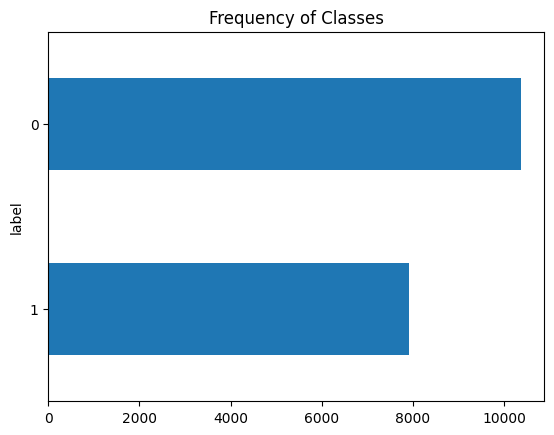

In [7]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

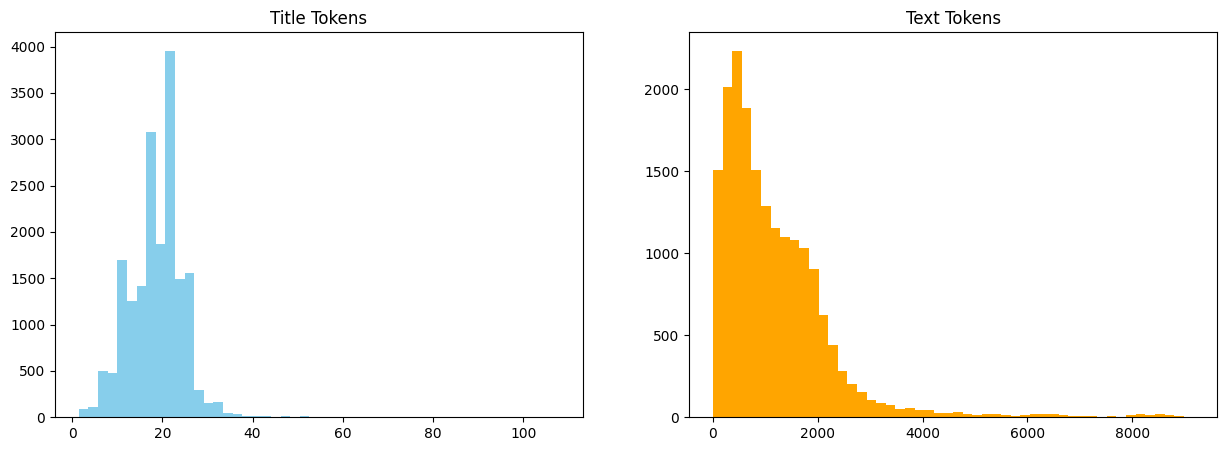

In [8]:
# 1.5 tokens per word on average
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)


fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

## Data Loader and Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

# 70% for training, 10% validation, 20% test 
train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape, df.shape



((12796, 7), (3656, 7), (1829, 7), (18281, 7))

In [10]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

## Data Tokenization

In [11]:
from transformers import AutoTokenizer

text = "Machine learning is awesome!! Thanks KGP Talkie."

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [12]:
distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 },
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=1000

In [13]:
distilbert_tokens, mobilebert_tokens, tinybert_tokens

(['machine',
  'learning',
  'is',
  'awesome',
  '!',
  '!',
  'thanks',
  'kg',
  '##p',
  'talk',
  '##ie',
  '.'],
 ['machine',
  'learning',
  'is',
  'awesome',
  '!',
  '!',
  'thanks',
  'kg',
  '##p',
  'talk',
  '##ie',
  '.'],
 ['machine',
  'learning',
  'is',
  'awesome',
  '!',
  '!',
  'thanks',
  'kg',
  '##p',
  'talk',
  '##ie',
  '.'])

In [14]:
def tokenize(batch):
    temp = distilbert_tokenizer(batch['title'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 7979, 9452, 7436, 8685, 14043, 22017, 2098, 2012, 16392, 5984, 13641, 2154, 7700, 102, 0, 0, 0], [101, 1999, 5207, 1010, 14470, 16624, 6985, 2015, 1057, 1012, 1055, 1012, 3433, 2000, 9042, 13141, 5325, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [15]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

## Model Building

- `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs
- The first thing we need is a pretrained BERT-like model.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

In [16]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

model_ckpt = "distilbert-base-uncased"
# model_ckpt = "google/mobilebert-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
distilbert_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)




model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
distilbert_model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.46.3",
  "vocab_size": 30522
}

## Model Fine-Tuning

- https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [18]:
# Build compute metrics function
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [19]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
                                  output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch'
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [20]:
from transformers import Trainer

trainer = Trainer(
    model=distilbert_model,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=distilbert_tokenizer
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [21]:
trainer.train()

Step,Training Loss
500,0.229200
1000,0.172700
1500,0.151800
2000,0.094600
2500,0.069800
3000,0.078600
3500,0.047800
4000,0.015700
4500,0.027100


TrainOutput(global_step=4800, training_loss=0.09402698238690695, metrics={'train_runtime': 268.1579, 'train_samples_per_second': 143.154, 'train_steps_per_second': 17.9, 'total_flos': 953467218676224.0, 'train_loss': 0.09402698238690695, 'epoch': 3.0})

## Model Evaluation

In [22]:
preds_output = trainer.predict(encoded_dataset['test'])

In [23]:
preds_output.metrics

{'test_loss': 0.19706882536411285,
 'test_accuracy': 0.962800875273523,
 'test_runtime': 5.8832,
 'test_samples_per_second': 621.427,
 'test_steps_per_second': 77.678}

In [24]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_dataset['test'][:]['label']

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(label2id)))

              precision    recall  f1-score   support

        Real       0.97      0.97      0.97      2072
        Fake       0.95      0.96      0.96      1584

    accuracy                           0.96      3656
   macro avg       0.96      0.96      0.96      3656
weighted avg       0.96      0.96      0.96      3656



## Benchmarking

In [26]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [27]:
model_dict = {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "mobilebert": "google/mobilebert-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    def local_tokenizer(batch):
        temp = tokenizer(batch['title'], padding=True, truncation=True)
        return temp
    
    encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

    trainer = Trainer(
                model=model,
                compute_metrics=compute_metrics,
                train_dataset=encoded_dataset['train'],
                eval_dataset=encoded_dataset['validation'],
                tokenizer=tokenizer
            )
    
    trainer.train()

    preds = trainer.predict(encoded_dataset['test'])

    return preds.metrics
    

import time
model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()
    
    model_performance[model_name] = {model_name:result, "time taken": end-start}




Training Model:  bert-base


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.266600
1000,0.197300
1500,0.174000
2000,0.123400
2500,0.094500
3000,0.091200
3500,0.061100
4000,0.021100
4500,0.044200





Training Model:  distilbert


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.243100
1000,0.166200
1500,0.149500
2000,0.101000
2500,0.079000
3000,0.068700
3500,0.052800
4000,0.018100
4500,0.029300





Training Model:  mobilebert


pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,42952.108000
1000,0.192100
1500,0.168700
2000,0.124900
2500,0.207600
3000,0.151800
3500,0.073300
4000,0.453300
4500,0.050800





Training Model:  tinybert


pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.297700
1000,0.213700
1500,0.192400
2000,0.150400
2500,0.126500
3000,0.121800
3500,0.100500
4000,0.085000
4500,0.080200


In [28]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.22135160863399506,
   'test_accuracy': 0.9617067833698031,
   'test_f1': 0.9617442768345291,
   'test_runtime': 11.0081,
   'test_samples_per_second': 332.12,
   'test_steps_per_second': 41.515},
  'time taken': 526.637797832489},
 'distilbert': {'distilbert': {'test_loss': 0.1667098104953766,
   'test_accuracy': 0.9660831509846827,
   'test_f1': 0.9661049788299265,
   'test_runtime': 5.8712,
   'test_samples_per_second': 622.705,
   'test_steps_per_second': 77.838},
  'time taken': 282.0126714706421},
 'mobilebert': {'mobilebert': {'test_loss': 0.1944858878850937,
   'test_accuracy': 0.9644420131291028,
   'test_f1': 0.9644446454211605,
   'test_runtime': 16.2486,
   'test_samples_per_second': 225.004,
   'test_steps_per_second': 28.125},
  'time taken': 682.5612580776215},
 'tinybert': {'tinybert': {'test_loss': 0.22982069849967957,
   'test_accuracy': 0.9535010940919038,
   'test_f1': 0.9533969883368834,
   'test_runtime': 2.4799,
   'test

In [29]:
# bert-base time taken: 679.7081322669983},
# distilbert time taken: 365.0743615627289},
# mobilebert time taken : 902.2547216415405},
# tinybert time taken: 107.46117568016052

# Model Load and Save

In [30]:
trainer.save_model("fake_news")

In [31]:
from transformers import pipeline

classifier = pipeline('text-classification', model= 'fake_news')


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [32]:
classifier("some text data")

[{'label': 'Fake', 'score': 0.999821126461029}]